<a href="https://colab.research.google.com/github/Mike-Xie/DS-Unit-2-Build-Week/blob/master/Mike_Xie_Unit_2_Build_Week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [2]:
!wget https://github.com/bowswung/voobly-scraper/raw/master/data/MatchData/20190208/matchDump.csv.zip

--2020-01-08 17:42:43--  https://github.com/bowswung/voobly-scraper/raw/master/data/MatchData/20190208/matchDump.csv.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/bowswung/voobly-scraper/master/data/MatchData/20190208/matchDump.csv.zip [following]
--2020-01-08 17:42:43--  https://media.githubusercontent.com/media/bowswung/voobly-scraper/master/data/MatchData/20190208/matchDump.csv.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49029198 (47M) [application/zip]
Saving to: ‘matchDump.csv.zip’

matchDump.csv.zip   100%[===================>]  46.76M   199MB/s    in 0.2s    


In [3]:
!unzip matchDump.csv.zip

Archive:  matchDump.csv.zip
  inflating: matchDump.csv           


In [4]:
!head matchDump.csv

MatchId,MatchUrl,MatchDate,MatchDuration,MatchLadder,MatchMap,MatchMods,MatchPlayerId,MatchPlayerName,MatchPlayerTeam,MatchPlayerCivId,MatchPlayerCivName,MatchPlayerWinner,MatchPlayerPreRating,MatchPlayerPostRating,MatchPlayerRecording
17827685,https://www.voobly.com/match/view/17827685,2018-05-27T18:14:00,520,Match Stats Only,=V= CBA Hero AC V13.scx,v1.5 Beta R6,123972487,___Oreo,1,9,Saracens,1,1584,1600,
17827685,https://www.voobly.com/match/view/17827685,2018-05-27T18:14:00,520,Match Stats Only,=V= CBA Hero AC V13.scx,v1.5 Beta R6,125049367,___Dm,2,9,Saracens,0,1616,1600,
17827728,https://www.voobly.com/match/view/17827728,2018-05-27T18:21:00,661,Match Stats Only,=V= CBA Hero AC V13.scx,v1.5 Beta R6,123972487,___Oreo,1,13,Celts,1,1584,1600,
17827728,https://www.voobly.com/match/view/17827728,2018-05-27T18:21:00,661,Match Stats Only,=V= CBA Hero AC V13.scx,v1.5 Beta R6,125049367,___Dm,2,13,Celts,0,1616,1600,
17832641,https://www.voobly.com/match/view/17832641,2018-05-28T11:25:00,762,

In [78]:
# imports 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
import pandas as pd
import seaborn as sns
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 100

# drop columns with meta data that are useless
df = pd.read_csv('matchDump.csv', header=0, engine='python')

cols_to_keep = ['MatchId','MatchMods','MatchMap','MatchLadder','MatchDuration','MatchPlayerTeam','MatchPlayerCivId','MatchPlayerCivName','MatchPlayerWinner','MatchPlayerPreRating']

df = df[cols_to_keep]

df.shape


(1263808, 10)

In [79]:
df.head(5)

,MatchId,MatchMods,MatchMap,MatchLadder,MatchDuration,MatchPlayerTeam,MatchPlayerCivId,MatchPlayerCivName,MatchPlayerWinner,MatchPlayerPreRating
0,17827685,v1.5 Beta R6,=V= CBA Hero AC V13.scx,Match Stats Only,520,1,9,Saracens,1,1584
1,17827685,v1.5 Beta R6,=V= CBA Hero AC V13.scx,Match Stats Only,520,2,9,Saracens,0,1616
2,17827728,v1.5 Beta R6,=V= CBA Hero AC V13.scx,Match Stats Only,661,1,13,Celts,1,1584
3,17827728,v1.5 Beta R6,=V= CBA Hero AC V13.scx,Match Stats Only,661,2,13,Celts,0,1616
4,17832641,v1.5 Beta R6,=V= CBA Hero AC V13.scx,Match Stats Only,762,1,14,Spanish,1,1584


# Choose Target

In [0]:
# I want to predict which player wins

target = 'MatchPlayerWinner'

# This is 50/50 since odds are P1 and evens are P2 for a baseline

In [81]:
df[target].describe()

count     1263808
unique          3
top             0
freq       647589
Name: MatchPlayerWinner, dtype: object

In [82]:
df['MatchLadder'].value_counts()

RM - Team           723786
RM - 1v1            411718
Match Stats Only     81083
DM - Team            40249
DM - 1v1              6972
Name: MatchLadder, dtype: int64

In [83]:
# only do 1v1 on random map game mode

rm_1v1 = df[df['MatchLadder'] == 'RM - 1v1']

# remove ones with errors

rm_1v1 = rm_1v1[rm_1v1.MatchPlayerPreRating != '*VooblyErrorPlayerNotFound*']

# drop matchladder now since it's all the same

rm_1v1 = rm_1v1.drop(labels=['MatchLadder','MatchPlayerCivName','MatchPlayerTeam'], axis=1)

rm_1v1.head()

,MatchId,MatchMods,MatchMap,MatchDuration,MatchPlayerCivId,MatchPlayerWinner,MatchPlayerPreRating
728,18658367,"v1.5 Beta R7, WololoKingdoms",Arabia,1055,16,1,1599
729,18658367,"v1.5 Beta R7, WololoKingdoms",Arabia,1055,11,0,1600
730,18658419,1.4 RC,Custom,3361,18,1,1629
731,18658419,1.4 RC,Custom,3361,17,0,1548
732,18658476,"v1.5 Beta R7, WololoKingdoms",Nomad,3369,6,1,1975


In [84]:
rm_1v1.dtypes

MatchId                  int64
MatchMods               object
MatchMap                object
MatchDuration            int64
MatchPlayerCivId        object
MatchPlayerWinner       object
MatchPlayerPreRating    object
dtype: object

In [0]:
rm_1v1['MatchPlayerCivId'] = rm_1v1['MatchPlayerCivId'].astype(int)
rm_1v1['MatchPlayerWinner'] = rm_1v1['MatchPlayerWinner'].astype(int)
rm_1v1['MatchPlayerPreRating'] = rm_1v1['MatchPlayerPreRating'].astype(int)

In [86]:
rm_1v1.dtypes 

MatchId                  int64
MatchMods               object
MatchMap                object
MatchDuration            int64
MatchPlayerCivId         int64
MatchPlayerWinner        int64
MatchPlayerPreRating     int64
dtype: object

In [87]:
rm_1v1['MatchMods'].describe()

count                           411632
unique                              40
top       v1.5 Beta R7, WololoKingdoms
freq                            293214
Name: MatchMods, dtype: object

In [88]:
rm_1v1['MatchMap'].describe()

count     411632
unique        57
top       Arabia
freq      274278
Name: MatchMap, dtype: object

In [89]:
rm_1v1.tail()

,MatchId,MatchMods,MatchMap,MatchDuration,MatchPlayerCivId,MatchPlayerWinner,MatchPlayerPreRating
1263771,19250562,"v1.5 Beta R7, WololoKingdoms",Arabia,4797,8,0,1695
1263772,19250571,"v1.5 Beta R7, WololoKingdoms",Custom,2501,13,1,1933
1263773,19250571,"v1.5 Beta R7, WololoKingdoms",Custom,2501,12,0,1909
1263774,19250581,"v1.5 Beta R7, WololoKingdoms",Custom,4080,24,1,1542
1263775,19250581,"v1.5 Beta R7, WololoKingdoms",Custom,4080,19,0,1479


In [90]:
y = rm_1v1[target]

y.nunique()

2

In [91]:
y.value_counts() # baseline is 50/50 since only P1 or P2 can win a 1v1

1    205816
0    205816
Name: MatchPlayerWinner, dtype: int64

In [92]:
# re-arranging dataframe since right now, odd player always wins which makes the model always guess player one wins

first_players = rm_1v1[::2]
second_players = rm_1v1[1::2]


first_players.shape, second_players.shape

((205816, 7), (205816, 7))

In [93]:
first_players.head()

,MatchId,MatchMods,MatchMap,MatchDuration,MatchPlayerCivId,MatchPlayerWinner,MatchPlayerPreRating
728,18658367,"v1.5 Beta R7, WololoKingdoms",Arabia,1055,16,1,1599
730,18658419,1.4 RC,Custom,3361,18,1,1629
732,18658476,"v1.5 Beta R7, WololoKingdoms",Nomad,3369,6,1,1975
734,18658489,1.4 RC,Custom,1891,12,1,1415
736,18658492,"v1.5 Beta R7, WololoKingdoms",Custom,3832,22,1,1385


In [94]:
second_players.head()

,MatchId,MatchMods,MatchMap,MatchDuration,MatchPlayerCivId,MatchPlayerWinner,MatchPlayerPreRating
729,18658367,"v1.5 Beta R7, WololoKingdoms",Arabia,1055,11,0,1600
731,18658419,1.4 RC,Custom,3361,17,0,1548
733,18658476,"v1.5 Beta R7, WololoKingdoms",Nomad,3369,17,0,2065
735,18658489,1.4 RC,Custom,1891,18,0,1535
737,18658492,"v1.5 Beta R7, WololoKingdoms",Custom,3832,8,0,1600


In [95]:
p2_names = {
    "MatchPlayerCivId" : "MatchPlayerCivId2",
    "MatchPlayerPreRating" : "MatchPlayerPreRating2",
    "MatchPlayerPostRating" : "MatchPlayerPostRating2"
}

second_players = second_players.rename(columns=p2_names)

drop_cols = ['MatchMods','MatchDuration','MatchPlayerWinner', 'MatchMap']
second_players = second_players.drop(labels=drop_cols, axis=1)

second_players.head()

,MatchId,MatchPlayerCivId2,MatchPlayerPreRating2
729,18658367,11,1600
731,18658419,17,1548
733,18658476,17,2065
735,18658489,18,1535
737,18658492,8,1600


In [0]:
# merge first and second players so each row has match data for both players since
# the features we care about are relative like their relative elo difference

rm_1v1 = first_players.merge(second_players, on='MatchId')


In [0]:
# set matchID as index

rm_1v1 = rm_1v1.set_index('MatchId')

In [98]:
# split set in half and reverse P1 and P2 in second half
# so half of the data has P1 and P2 as winner

from sklearn.model_selection import train_test_split

fst, snd = train_test_split(rm_1v1, train_size=0.5, test_size=0.5)

fst.shape, snd.shape

snd_names = {
    "MatchPlayerCivId" : "MatchPlayerCivId2",
    "MatchPlayerPreRating" : "MatchPlayerPreRating2",
    "MatchPlayerPostRating" : "MatchPlayerPostRating2",
    "MatchPlayerCivId2" : "MatchPlayerCivId",
    "MatchPlayerPreRating2" : "MatchPlayerPreRating",
    "MatchPlayerPostRating2" : "MatchPlayerPostRating"
}

snd = snd.rename(columns=snd_names)
snd['MatchPlayerWinner'] = snd['MatchPlayerWinner'].map({1:0})

snd = snd.fillna(0)

snd.head()


,MatchMods,MatchMap,MatchDuration,MatchPlayerCivId2,MatchPlayerWinner,MatchPlayerPreRating2,MatchPlayerCivId,MatchPlayerPreRating
MatchId,,,,,,,,
19044674,"v1.5 Beta R7, Small Trees - N",Nomad,2066,14,0,1669,18,1625
19191267,"v1.5 Beta R7, WololoKingdoms",Arabia,871,29,0,1751,13,1690
18781992,"v1.5 Beta R7, WololoKingdoms",Custom,1697,23,0,2382,26,2427
19070033,"v1.5 Beta R7, WololoKingdoms",Arabia,2724,7,0,1610,26,1594
18841274,"v1.5 Beta R7, WololoKingdoms",Arabia,1640,27,0,1750,9,1711


In [99]:
fst.head()

,MatchMods,MatchMap,MatchDuration,MatchPlayerCivId,MatchPlayerWinner,MatchPlayerPreRating,MatchPlayerCivId2,MatchPlayerPreRating2
MatchId,,,,,,,,
18726012,"v1.5 Beta R7, WololoKingdoms",Arabia,1777,8,1,1658,18,1697
18839282,"v1.5 Beta R7, WololoKingdoms",Arabia,1505,1,1,1491,9,1478
18902536,"v1.5 Beta R7, WololoKingdoms",Arabia,5111,28,1,1681,12,1714
18709844,"v1.5 Beta R7, WololoKingdoms",Arena,2509,20,1,1710,28,1784
18785920,"v1.5 Beta R7, WololoKingdoms",Arabia,2103,25,1,1482,1,1244


In [0]:
# data frame is finally ready to have features engineered

rm_1v1 = snd.append(fst, sort=True)

# Feature Engineering 

In [101]:

rm_1v1['EloDifference'] = rm_1v1['MatchPlayerPreRating'] - rm_1v1['MatchPlayerPreRating2']

rm_1v1.head()

,MatchDuration,MatchMap,MatchMods,MatchPlayerCivId,MatchPlayerCivId2,MatchPlayerPreRating,MatchPlayerPreRating2,MatchPlayerWinner,EloDifference
MatchId,,,,,,,,,
19044674,2066,Nomad,"v1.5 Beta R7, Small Trees - N",18,14,1625,1669,0,-44
19191267,871,Arabia,"v1.5 Beta R7, WololoKingdoms",13,29,1690,1751,0,-61
18781992,1697,Custom,"v1.5 Beta R7, WololoKingdoms",26,23,2427,2382,0,45
19070033,2724,Arabia,"v1.5 Beta R7, WololoKingdoms",26,7,1594,1610,0,-16
18841274,1640,Arabia,"v1.5 Beta R7, WololoKingdoms",9,27,1711,1750,0,-39


In [102]:
rm_1v1.columns

Index(['MatchDuration', 'MatchMap', 'MatchMods', 'MatchPlayerCivId',
       'MatchPlayerCivId2', 'MatchPlayerPreRating', 'MatchPlayerPreRating2',
       'MatchPlayerWinner', 'EloDifference'],
      dtype='object')

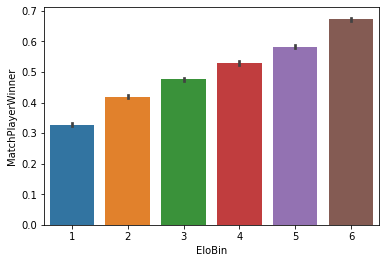

In [103]:
rm_1v1['EloBin'] = pd.qcut(rm_1v1['EloDifference'], 6, labels=[1,2,3,4,5,6])

sns.barplot(x='EloBin', y='MatchPlayerWinner', data=rm_1v1);

# ok this looks reasonable, a lot lower than expected because of smurfs but
# will address difficulty of smurf detection/lack of 'trueElo' in blog

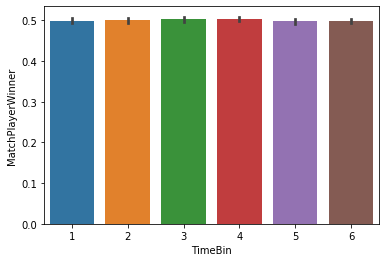

In [104]:
rm_1v1['TimeBin'] = pd.qcut(rm_1v1['MatchDuration'], 6, labels=[1,2,3,4,5,6])

sns.barplot(x='TimeBin', y='MatchPlayerWinner', data=rm_1v1);

# ok this is useless by itself, let's see if any factions are rush/late game
# and make a feature around that

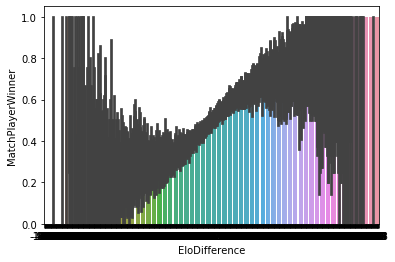

In [105]:
sns.barplot(x='EloDifference', y='MatchPlayerWinner', data=rm_1v1);

# not sure why it does an inverse color thing above
# TODO: remove bottom margin labels
# again, the smurfing is ruining it 

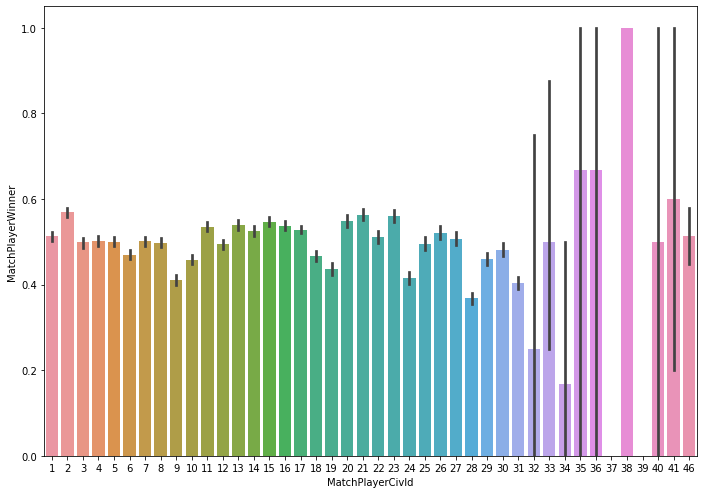

In [108]:
a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax=ax, x='MatchPlayerCivId', y='MatchPlayerWinner', data=rm_1v1); 

# ok prob bin some of the less popular ones together
# TODO: use this and some tier lists to make a tier of race and then relative tier advantage feature

In [127]:
rm_1v1['MatchPlayerCivId'].value_counts()

17    15646
12     8189
16     7959
13     7875
7      7799
15     7784
2      7747
11     7678
1      7618
14     7528
18     7523
3      7489
4      7464
5      7429
8      7415
6      7383
9      7304
10     7268
23     4804
22     4796
21     4785
20     4775
27     4643
26     4629
19     4618
31     4600
29     4590
28     4586
30     4565
25     4558
24     4520
46      214
33        8
34        6
41        5
32        4
35        3
36        3
38        2
40        2
37        1
39        1
Name: MatchPlayerCivId, dtype: int64

In [129]:
rm_1v1['MatchMods'].value_counts()

# I don't play with balance mods and have no idea how these influence balance
# Outside of time budget
# However I do know that cosmetic mods are optional and one sided only
# Like with removing shrubs and smaller trees and these do give an advantage

v1.5 Beta R7, WololoKingdoms     146607
v1.5 Beta R7                      38850
v1.5 Beta R7, Allied Vision        6813
v1.5 Beta R7, Small Trees - N      4599
1.4 RC                             4394
1.4 RC, WololoKingdoms              708
v1.5 Beta R7, Advanced Statis       705
v1.5 Beta R7, Allied Vision -       655
v1.5 Beta R7, X-Patch with Al       596
v1.5 Beta R7, Longer Lasting        498
1.4 RC, Allied Vision               448
v1.5 Beta R7, 1.0 Patch Mod         191
1.4 RC, Small Trees - No Snow       181
v1.5 Beta R7, Realms                150
1.4 RC, Advanced Statistics          97
v1.5 Beta R7, No Walls Mod           70
1.4 RC, Allied Vision - Advan        48
v1.5 Beta R7, Mad Random Maps        44
v1.5 RC, WololoKingdoms              41
v1.5 Beta R7, LN FFA rules mo        26
v1.5 Beta R7, 5th Age Mod            26
1.4 RC, X-Patch with Allied V        14
1.4 RC, 1.0 Patch Mod                 9
1.4 RC, 5th Age Mod                   9
v1.5 RC                               4


Wololo Kingdoms vs Vanilla Win Rates from Reddit

![Wololo Kingdoms vs Vanilla Game](https://i.redd.it/b5x2mnh608w01.png)

In [110]:
rm_1v1.columns

Index(['MatchDuration', 'MatchMap', 'MatchMods', 'MatchPlayerCivId',
       'MatchPlayerCivId2', 'MatchPlayerPreRating', 'MatchPlayerPreRating2',
       'MatchPlayerWinner', 'EloDifference', 'EloBin', 'TimeBin'],
      dtype='object')

In [111]:
rm_1v1.head()

,MatchDuration,MatchMap,MatchMods,MatchPlayerCivId,MatchPlayerCivId2,MatchPlayerPreRating,MatchPlayerPreRating2,MatchPlayerWinner,EloDifference,EloBin,TimeBin
MatchId,,,,,,,,,,,
19044674,2066,Nomad,"v1.5 Beta R7, Small Trees - N",18,14,1625,1669,0,-44,2,3
19191267,871,Arabia,"v1.5 Beta R7, WololoKingdoms",13,29,1690,1751,0,-61,2,1
18781992,1697,Custom,"v1.5 Beta R7, WololoKingdoms",26,23,2427,2382,0,45,5,2
19070033,2724,Arabia,"v1.5 Beta R7, WololoKingdoms",26,7,1594,1610,0,-16,3,4
18841274,1640,Arabia,"v1.5 Beta R7, WololoKingdoms",9,27,1711,1750,0,-39,2,2


# PREP DATA FOR MODEL

In [112]:
# train test split
from sklearn.model_selection import train_test_split

train, val = train_test_split(rm_1v1, train_size = 0.8, test_size = 0.2)

train.shape, val.shape

((164652, 11), (41164, 11))

In [0]:
# set up features for model
target = 'MatchPlayerWinner'
features = [
            'MatchMods', 
            'MatchMap', 
            'MatchDuration',
      #  'MatchPlayerCivId', 
       # 'MatchPlayerPreRating',
     #   'MatchPlayerCivId2', 
       # 'MatchPlayerPreRating2',
        'EloDifference', 
        'EloBin']
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

# Linear Regression

In [141]:
from sklearn import linear_model
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    LinearRegression()
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

print('Train Accuracy', pipeline.score(X_train, y_train))

print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.05296271029587508
Validation Accuracy 0.054404630802611154


# Decision Forest

In [139]:
from sklearn.ensemble import RandomForestClassifier
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(n_estimators = 100, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

print('Train Accuracy', pipeline.score(X_train, y_train))

print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.9872154604863591
Validation Accuracy 0.5447721309882422


# Decision Tree

In [140]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    
    DecisionTreeClassifier(random_state=42)
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

print('Train Accuracy', pipeline.score(X_train, y_train))

print('Validation Accuracy', pipeline.score(X_val, y_val))

# above baseline

Train Accuracy 0.9872519009790346
Validation Accuracy 0.5286658245068506


# XGBClassifier

In [137]:
from xgboost import XGBClassifier
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

print('Train Accuracy', pipeline.score(X_train, y_train))

print('Validation Accuracy', pipeline.score(X_val, y_val))


Train Accuracy 0.5956988071812064
Validation Accuracy 0.5948158585171509


# Feature Importances

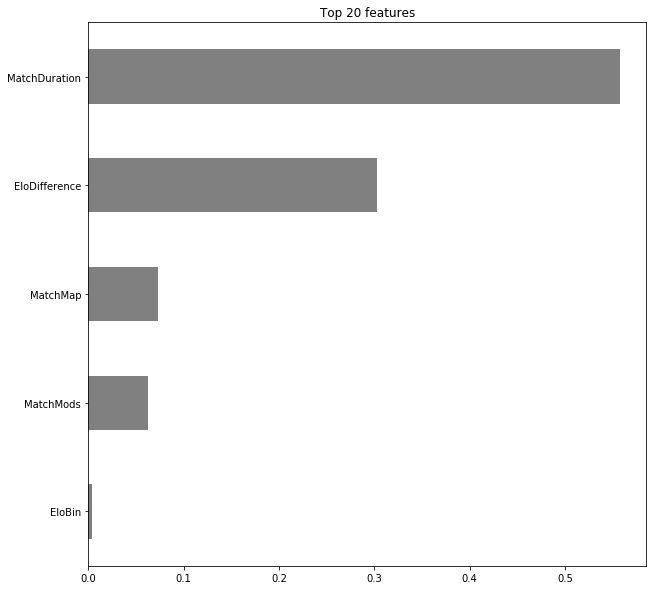

In [119]:
rf = pipeline.named_steps['decisiontreeclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n=20

plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

# PDP and Shapely Plots

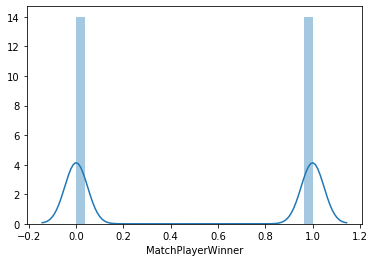

In [120]:
sns.distplot(y_train);

In [121]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

# slightly above baseline!

Linear Regression R^2 0.0535562117393028


In [134]:
# TODO: see if can get higher

from sklearn.metrics import r2_score, accuracy_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))


Gradient Boosting R^2 0.06071901802427593


In [0]:
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt


(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f48216157b8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f483ff00da0>})

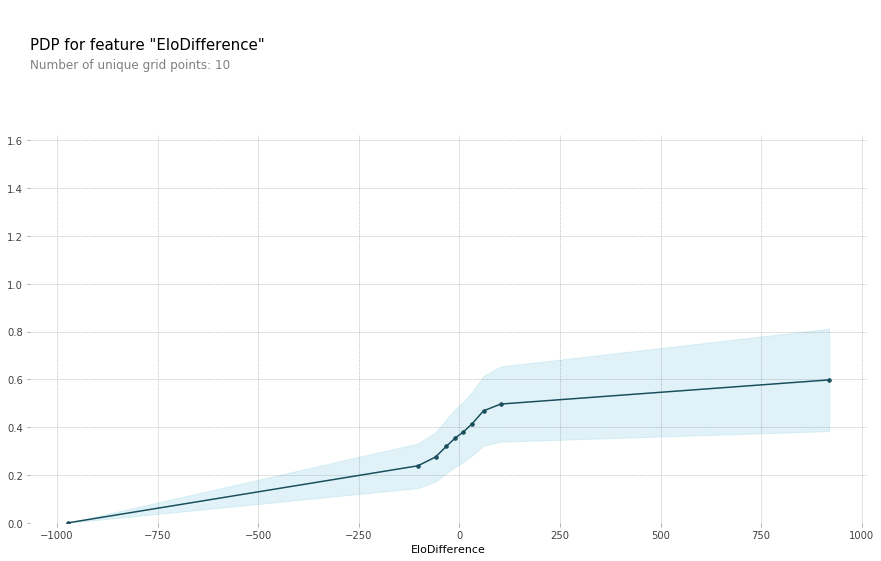

In [124]:
if 'google.colab' in sys.modules:

      !pip install pdpbox
      !pip install shap

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'EloDifference'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature)

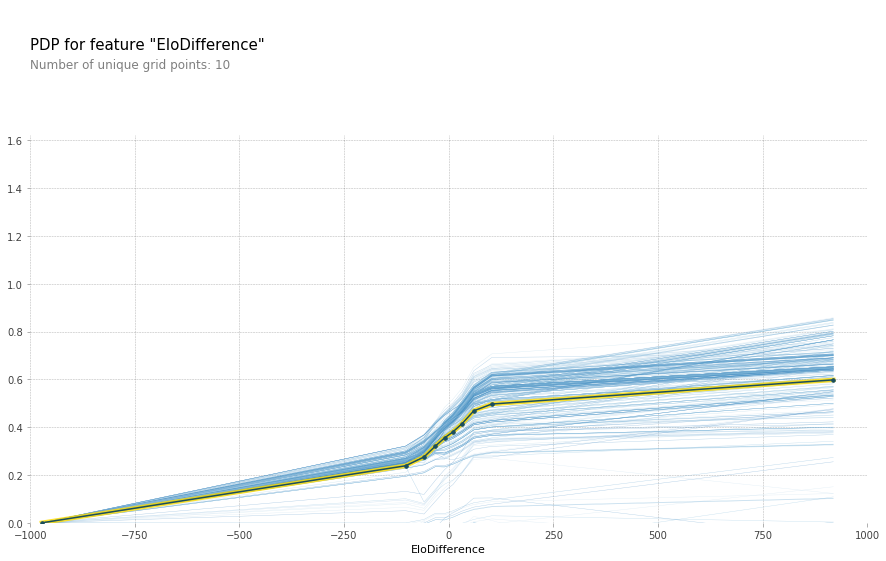

In [125]:
# Plot PDP with 100 ICE curves
# PDP: Partial Dependence Plot
# ICE: Individual Conditional Expectation
pdp_plot(isolated, feature_name=feature, plot_lines=True, 
         frac_to_plot=0.01)

plt.xlim(-1000,1000);

In [145]:
rm_1v1.MatchDuration.describe()

count    205816.000000
mean       2476.064514
std        1146.316560
min           5.000000
25%        1739.000000
50%        2441.000000
75%        3087.000000
max       38404.000000
Name: MatchDuration, dtype: float64

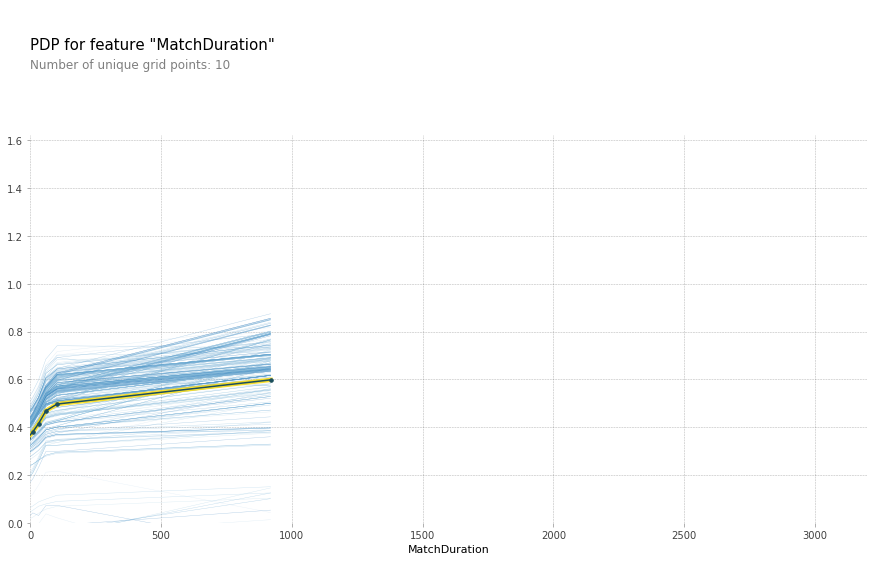

In [147]:
pdp_plot(isolated, feature_name='MatchDuration', plot_lines=True, 
         frac_to_plot=0.01)


plt.xlim(0,3200);